### Predict future loan demand or interest rates using time series analysis.

In [1]:
# Import necessary libraries
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import warnings

# Disable warnings
warnings.filterwarnings('ignore')

# Initialize Fred API with your API key
fred = Fred(api_key='dc7c3ec781759add86587b96ae2c8b0a')

# Fetch U.S. 10-Year Treasury Constant Maturity Rate (DGS10)
data = fred.get_series('DGS10')
#data = fred.get_series_vintage_dates('DGS10')

# Convert to a pandas DataFrame
data = pd.DataFrame(data, columns=['Interest Rate'])
data.index.name = 'Date'
data.reset_index(inplace=True)

# Display first few rows of the data
print(data.head())


        Date  Interest Rate
0 1962-01-02           4.06
1 1962-01-03           4.03
2 1962-01-04           3.99
3 1962-01-05           4.02
4 1962-01-08           4.03


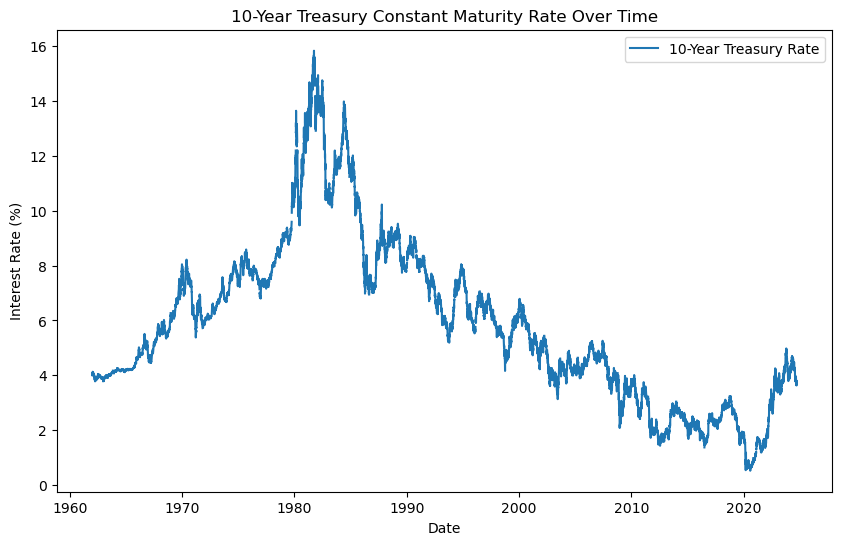

In [2]:
# Plot the interest rates over time
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Interest Rate'], label='10-Year Treasury Rate')
plt.title('10-Year Treasury Constant Maturity Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.show()

In [3]:
#Check for stationarity with ADF Test
adf_result = adfuller(data['Interest Rate'].dropna())
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -1.683651597947681
p-value: 0.4395547377651342


Training data shape: (13094, 2)
Testing data shape: (3274, 2)


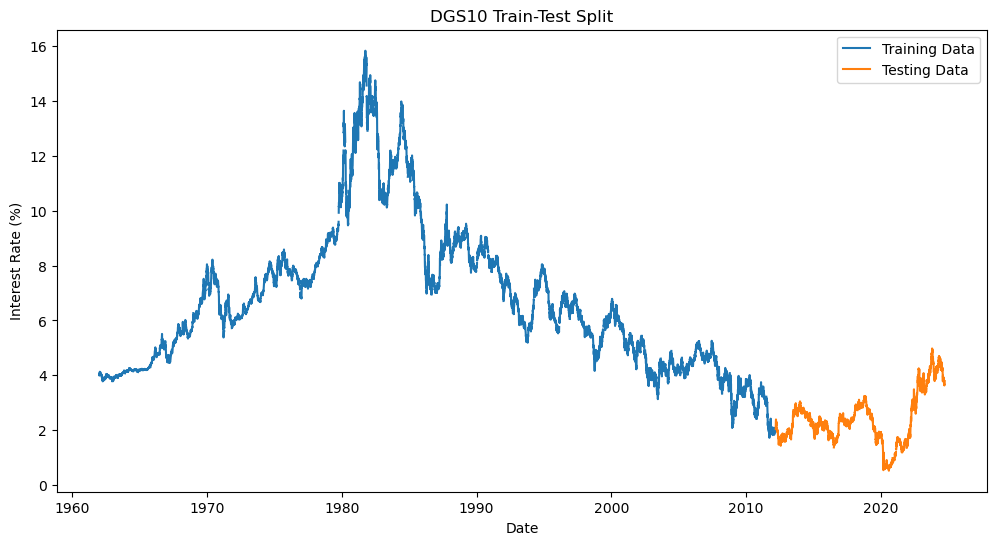

In [5]:
# Sort the data by date to ensure chronological order
data = data.sort_values('Date')

# Define the split point (e.g., use the last 20% of the data for testing)
split_point = int(len(data) * 0.8)


# Split the data
train_data = data.iloc[:split_point]
test_data = data.iloc[split_point:]

# If you need the data as numpy arrays for some models
X_train = train_data['Interest Rate'].values
X_test = test_data['Interest Rate'].values

# If you need datetime index
train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# Visualize the split
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Interest Rate'], label='Training Data')
plt.plot(test_data.index, test_data['Interest Rate'], label='Testing Data')
plt.title('DGS10 Train-Test Split')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.show()


In [ ]:

# Step 3: Fit ARIMA model (Assuming p, d, q = 1, 1, 1 for simplicity)
model = ARIMA(data['Interest Rate'], order=(1, 1, 1))
arima_result = model.fit()

# Display ARIMA model summary
print(arima_result.summary())

# Step 4: Plot the fitted values vs actual interest rate data
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Interest Rate'], label='Actual Data')
plt.plot(data['Date'][1:], arima_result.fittedvalues, color='red', label='Fitted ARIMA Model')
plt.title('ARIMA Model Fitted vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.show()

# Step 5: Forecast next 12 months using the ARIMA model
forecast = arima_result.forecast(steps=12)

# Create a new date index for the forecasted values
forecast_dates = pd.date_range(start=data['Date'].iloc[-1], periods=12, freq='M')

# Plot the actual data along with the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Interest Rate'], label='Historical Data')
plt.plot(forecast_dates, forecast, label='Forecasted Data', color='red')
plt.title('Forecast for U.S. 10-Year Treasury Rate')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.show()

# Step 6: Calculate evaluation metrics (MAE, RMSE)
y_true = data['Interest Rate'].dropna()
y_pred = arima_result.fittedvalues

mae = mean_absolute_error(y_true[1:], y_pred)
rmse = np.sqrt(mean_squared_error(y_true[1:], y_pred))

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
